In [1]:
!pip install japanize_matplotlib #matplotlib numpy plotly networkx sklearn はプリインストール済み

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 7.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=3320db1e2973f0082a8bae889aca40ed7dccf6d793c6983faaba2a0cd1a76f52
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [2]:
# 標準ライブラリ
import glob
import itertools
import logging
import pickle
import random

import japanize_matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx  # グラフ/ネットワーク理論系の計算を行うためのPythonのパッケージ
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    calinski_harabasz_score,
    silhouette_samples,
    silhouette_score,
)
from tqdm import tqdm

# random_stateで使う定数
SEED = 42

In [3]:
# 関数群
def best_kmeans(X, max_range=np.arange(2, 11), criterion="silhouette"):
    """
    Return the best K-Means clustering given the data, a range of K values, and a K-selection criterion.

    :param X: usage matrix (made of usage vectors)
    :param max_range: range within the number of clusters should lie
    :param criterion: K-selection criterion: 'silhouette' or 'calinski'
    :return: best_model: KMeans model (sklearn.cluster.Kmeans) with best clustering according to the criterion
              scores: list of tuples (k, s) indicating the clustering score s obtained using k clusters
    """
    assert criterion in ["silhouette", "calinski", "harabasz", "calinski-harabasz"]
    best_n_cluster, best_model, best_score = 1, None, -1
    scores = []
    # クラスター数2から11までの間で最もシルエットスコアが高いものを選択
    for k in max_range:
        print("n_cluster: {}".format(k))
        if k >= X.shape[0]:
            continue
        # クラスター数に応じてKmeansを行う
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        clusters = kmeans.fit_predict(X)
        # show_silhouette(kmeans)
        # シルエットスコアを算出
        if criterion == "silhouette":
            score = silhouette_score(X, clusters)
        else:
            score = calinski_harabasz_score(X, clusters)

        scores.append((k, score))

        # if two clusterings yield the same score, keep the one that results from a smaller K
        if score > best_score:
            best_n_cluster, best_model, best_clusters = k, kmeans, clusters
    print("best_n_cluster: {}".format(best_n_cluster))
    return best_n_cluster, best_model, best_clusters


def cluster_usages(
    Uw, method="kmeans", k_range=np.arange(2, 11), criterion="silhouette"
):
    """
    Return the best clustering model for a usage matrix.

    :param Uw: usage matrix
    :param method: K-Means or Gaussian Mixture Model ('kmeans' or 'gmm')
    :param k_range: range of possible K values (number of clusters)
    :param criterion: K selection criterion; depends on clustering method
    :return: best clustering model
    """
    # standardize usage matrix by removing the mean and scaling to unit variance
    X = preprocessing.StandardScaler().fit_transform(Uw)

    # get best model according to a K-selection criterion
    if method == "kmeans":
        best_n_cluster, best_model, best_clusters = best_kmeans(
            X, k_range, criterion=criterion
        )
    # elif method == 'gmm':
    #     best_model_aic, best_model_bic, _, _ = best_gmm(X, k_range)
    #     if criterion == 'aic':
    #         best_model = best_model_aic
    #     elif criterion == 'bic':
    #         best_model = best_model_bic
    #     else:
    #         raise ValueError('Invalid criterion {}. Choose "aic" or "bic".'.format(criterion))
    else:
        raise ValueError(
            'Invalid method "{}". Choose "kmeans" or "gmm".'.format(method)
        )

    return best_n_cluster, best_model, best_clusters


def show_scatter_plot(words=[], vectors=[], best_clusters=[]):
    # 次元削減
    tsne = TSNE(random_state=0, perplexity=30, learning_rate=500).fit_transform(
        np.array(vectors)
    )
    # 表示
    fig, ax = plt.subplots(1, 1, figsize=(40, 40))
    cmap = plt.get_cmap("Set1")
    # vocabとその位置に対応したクラスター番号を取り出す
    for idx, word in enumerate(words):
        # クラスターごとの色の指定
        cval = cmap(best_clusters[idx])
        # 各単語のベクトルを取得
        ax.scatter(tsne[idx, 0], tsne[idx, 1], marker=".", color=cval)
        # 単語を表示
        ax.annotate(word, xy=(tsne[idx, 0], tsne[idx, 1]), color=cval)

    plt.show()


# 横軸をシルエット係数、縦軸をクラスター番号としてプロットし、シルエット分析を可視化する関数
def show_silhouette(fitted_model, vectors=[]):
    cluster_labels = np.unique(fitted_model.labels_)
    num_cluster = cluster_labels.shape[0]
    # シルエット係数の計算
    silhouette_vals = silhouette_samples(vectors, fitted_model.labels_)
    # 可視化
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for idx, cls in enumerate(cluster_labels):
        cls_silhouette_vals = silhouette_vals[fitted_model.labels_ == cls]
        cls_silhouette_vals.sort()
        y_ax_upper += len(cls_silhouette_vals)
        cmap = cm.get_cmap("Spectral")
        # rgbaの配列
        rgba = list(cmap(idx / num_cluster))
        # alpha値を0.7にする
        rgba[-1] = 0.7
        plt.barh(
            y=range(y_ax_lower, y_ax_upper),
            width=cls_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=rgba,
        )
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(cls_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    # 各クラスターのシルエット係数の平均をプロット
    plt.axvline(silhouette_avg, color="orangered")
    plt.xlabel("sihouette coefficient")
    plt.ylabel("cluster")
    # クラスター番号をプロット
    plt.yticks(y_ticks, cluster_labels + 1)
    plt.show()

n_cluster: 2
n_cluster: 3
n_cluster: 4
n_cluster: 5
n_cluster: 6
n_cluster: 7
n_cluster: 8
n_cluster: 9
n_cluster: 10
best_n_cluster: 10
4 草
1 草
1 草
8 草
9 草
1 草
3 草
2 草
4 草
2 草
8 草
1 草
9 草
3 草
1 草
9 草
4 草
4 草
0 草
3 草
4 草
1 草
4 草
8 草
3 草
2 草
3 草
7 草
7 草
8 草
0 草
0 草
7 草
8 草
2 草
3 草
1 草
8 草
3 草
0 草
4 草
2 草
3 草
1 草
8 草
8 草
1 草
1 草
4 草
0 草
6 草
4 草
3 草
6 草
4 草
3 草
8 草
5 草
1 草
0 草
3 草
8 草
3 草
9 草
2 草
3 草
7 草
4 草
9 草
3 草
2 草
0 草
2 草
9 草
8 草
8 草
4 草
8 草
5 草
1 草
1 草
1 草
0 草
0 草
0 草
9 草
7 草
1 草
8 草
4 草
8 草
3 草
9 草
4 草
2 草
6 草
8 草
3 草
2 草
4 草
2 草
7 草
1 草
0 草
5 草
3 草
1 草
1 草
8 草
2 草
3 草
0 草
4 草
5 草
8 草
4 草
7 草
2 草
2 草
2 草
5 草
4 草
3 草
3 草
0 草
7 草
0 草
1 草
6 草
9 草
6 草
4 草
1 草
3 草
6 草
3 草
2 草
3 草
0 草
9 草
4 草
8 草
9 草
4 草
4 草
3 草
0 草
4 草
0 草
9 草
8 草
8 草
2 草
3 草
1 草
3 草
0 草
3 草
9 草
1 草
5 草
0 草
2 草
1 草
1 草
0 草
4 草
2 草
4 草
3 草
1 草
1 草
4 草
2 草
9 草
3 草
5 草
4 草
8 草
0 草
2 草
2 草
0 草
2 草
2 草
4 草
3 草
9 草
0 草
3 草
0 草
4 草
6 草
1 草
1 草
5 草
1 草
3 草
2 草
1 草
5 草
4 草
4 草
3 草
2 草
8 草
0 草
2 草
5 草
4 草
2 草
2 草
1 草
4 草
1 草
4 草

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


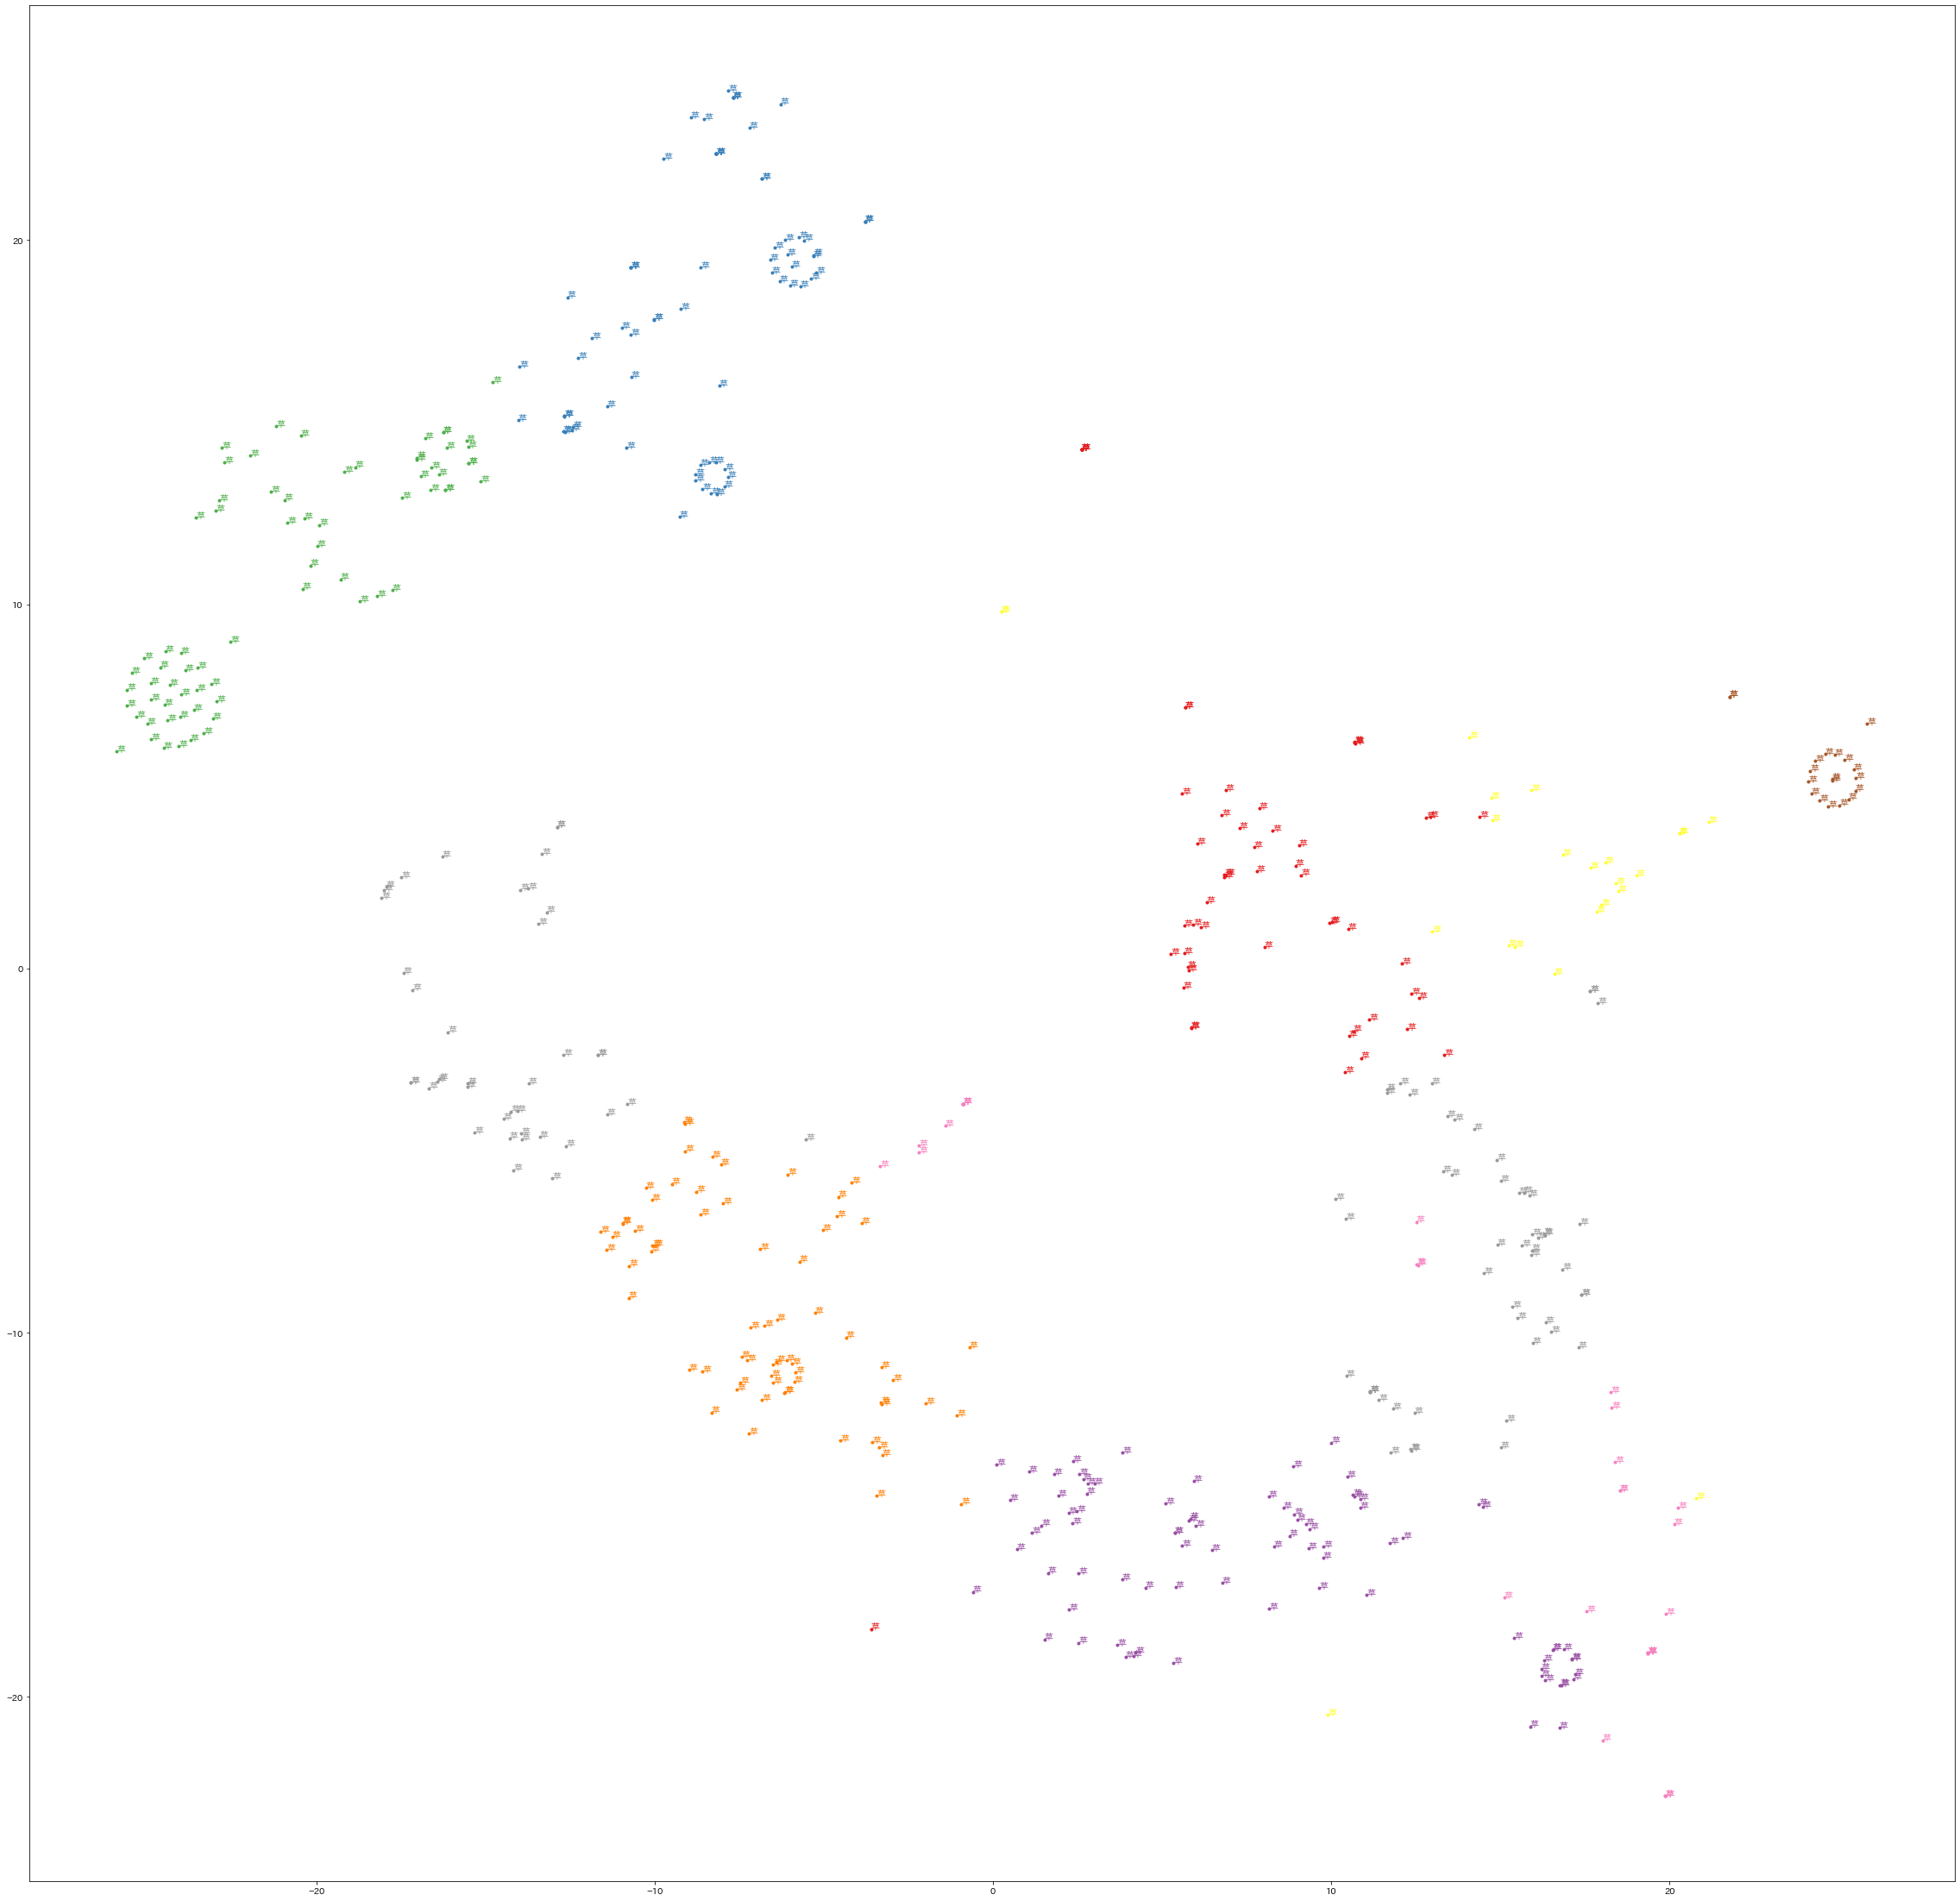

In [8]:
# 初期設定群
data_dir = "word-vectors"
path_list = glob.glob(data_dir + "/*.dict")
for path in path_list:
    with open(path, "rb") as f:
        usages = pickle.load(f)
    best_n_cluster, best_model, best_clusters = cluster_usages(
        Uw=np.array([u["vector"] for u in usages]),
        method="kmeans",
        k_range=np.arange(2, 11),
        criterion="silhouette",
    )
    relative_words = {}
    for id, word in zip(best_model.labels_, [u["word"] for u in usages]):
        if str(id) not in relative_words:
          relative_words[str(id)] = []
        relative_words[str(id)].append(word)
    for words in relative_words.values():
        print(words[:20])
    show_scatter_plot(
        [u["word"] for u in usages], [u["vector"] for u in usages], best_clusters
    )

In [3]:
ll = {'a':[(1,2,3,4),(5,6,7,8)]}
for l in ll:
  print(ll[l])
  Uw, _, _, _ = ll[l]
  print(Uw)

[(1, 2, 3, 4), (5, 6, 7, 8)]


ValueError: ignored